# **Sesión 1:** Calibración de Cámara 📷⚙️

## **Instalaciones**

In [2]:
!pip install imageio opencv-python


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Librerías**

In [3]:
from typing import List
import numpy as np
import imageio
import cv2
import copy
import glob
import os
from os.path import join, dirname

## **Apartado A: Calibración de cámara** (derecha e izquierda)

En este apartado se realiza la calibración de dos cámaras de un sistema estereoscópico. Para ello se trabajará con las imágenes de las carpetas ``left`` y ``right``. En primer lugar se trabajará con la carpeta ``left``. Posteriormente, deberá repetir el proceso con las imágenes en la carpeta ``right``. Ambas carpetas contienen imágenes con las que se calibrarán las cámaras. En ellas aparece el patrón de calibración en diferentes posiciones y orientaciones. Estas imágenes serán los datos de entrada.

Los pasos que deberá seguir para calibrar una cámara son:

1. Defina y ejecute el método para cargar imágenes ``load_images()``.
2. Detecte las esquinas de los patrones usando ``cv2.findChessboardCorners()``. Refine las detecciones con ``cv2.cornerSubPix()``.
3. Compruebe que las detecciones son correctas dibujando los resultados con ``cv2.drawChessboardCorners()``.
4. Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)`` que proporcione las coordenadas 3D de las esquinas del patrón. El sistema de referencia utilizado deberá estar anclado al propio patrón.
5. Utilice ``cv2.calibrateCamera`` para obtener los parámetros de calibración para la cámara izquierda.

### **Tarea A.1:** Defina y ejecute el método para cargar imágenes ``load_images()``.

In [4]:
def load_images(filenames: List) -> List:
    return [imageio.imread(filename) for filename in filenames]

In [5]:
# With glob

def get_paths(file: str, extra: str = "") -> List:
    if extra == "":
        path = join("..", "data", f"{file}/{file}*.jpg")
    else:
        path = join("..", "data", f"{file}/{extra}*.jpg")
    path = os.path.abspath(path)
    return [f for f in glob.glob(path)]


imgs_path = get_paths("left")
imgs = load_images(imgs_path)

C:\Users\javie\AppData\Local\Temp\ipykernel_27836\283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


### **Tarea A.2:** Detecte las esquinas de los patrones usando ``cv2.findChessboardCorners()``. Refine las detecciones con ``cv2.cornerSubPix()``.

In [6]:
# TODO Find corners with cv2.findChessboardCorners()
corners =  [cv2.findChessboardCorners(img, (8, 6)) for img in imgs]


In [7]:
imgs_gray = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in imgs]
corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01) # EPS + MAX_ITER, max 30 iterations, 0.01 accuracy(epsilon)
corners_refined = [cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria) if cor[0] else [] for i, cor in zip(imgs_gray, corners_copy)]



### **Tarea A.3:** Compruebe que las detecciones son correctas dibujando los resultados con ``cv2.drawChessboardCorners()``

In [8]:
# TODO Show images and save when needed

def show_image(img, title='image'):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def write_image(img, path):
    cv2.imwrite(path, img)

imgs_with_corners = [cv2.drawChessboardCorners(imgs[i], (8, 6), corners_refined[i], corners[i][0]) for i in range(len(imgs)) if corners[i][0]]
for i in range(len(imgs_with_corners)):
    show_image(imgs_with_corners[i], imgs_path[i])
    write_image(imgs_with_corners[i], join(dirname(imgs_path[i]), f"corners_{i}.jpg"))

# imgs_with_corners = get_imgs_corners_draw_write(imgs, corners)

### **Tarea A.4:** Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)``

In [9]:
# TODO Design the method. It should return a np.array with np.float32 elements
def get_chessboard_points(chessboard_shape, dx, dy):
    objp = np.zeros((chessboard_shape[0] * chessboard_shape[1], 3), np.float32)

    objp[:, :2] = np.mgrid[0:chessboard_shape[0], 0:chessboard_shape[1]].T.reshape(-1, 2)
    objp[:, 0] *= dx
    objp[:, 1] *= dy
    return objp

chessboard_points = [get_chessboard_points((8,6), 30, 30) for i in range(len(imgs))]

### **Tarea A.5:** Utilice ``cv2.calibrateCamera()`` para obtener los parámetros de calibración para la cámara izquierda

In [10]:
valid_corners = [cor[1] for cor in corners if cor[0]]
valid_corners = np.asarray(valid_corners, dtype=np.float32)

In [11]:
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, valid_corners, imgs_gray[0].shape[::-1], None, None)

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

In [12]:
# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[420.04820067   0.         156.17013229]
 [  0.         423.19989828 132.48442139]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-2.29154134e-01  3.18794487e+00  5.92006807e-03 -4.09074006e-03
  -2.50635145e+01]]
Root mean squared reprojection error:
 0.16919823622862215


### **Pregunta A.1:** Repita el proceso (carga de imágenes, detección y comprobación de esquinas, etc.) para la cámara derecha.

In [13]:
imgs_path = get_paths("right")
imgs = load_images(imgs_path)
corners = [cv2.findChessboardCorners(img, (8, 6)) for img in imgs]
imgs = [img for img, cor in zip(imgs, corners) if cor[0]]
corners = [cor for cor in corners if cor[0]]
corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01) # EPS + MAX_ITER, max 30 iterations, 0.01 accuracy(epsilon)
imgs_gray = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in imgs]
corners_refined = []
for i, cor in zip(imgs_gray, corners_copy):
    if cor[0]:
        corners_refined.append(cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria))
    else:
        print("No corners found in image")

imgs_with_corners = [cv2.drawChessboardCorners(imgs[i], (8, 6), corners_refined[i], corners[i][0]) for i in range(len(imgs)) if corners[i][0]]
for i in range(len(imgs_with_corners)):
    # show_image(imgs_with_corners[i], imgs_path[i])
    write_image(imgs_with_corners[i], join(dirname(imgs_path[i]), f"corners_{i}.jpg"))

# imgs_with_corners = get_imgs_corners_draw_write(imgs, corners)
chessboard_points = [get_chessboard_points((8,6), 30, 30) for i in range(len(imgs))]
valid_corners = [cor[1] for cor in corners if cor[0]]
valid_corners = np.asarray(valid_corners, dtype=np.float32)

rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, valid_corners, imgs_gray[0].shape[::-1], None, None)

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)


C:\Users\javie\AppData\Local\Temp\ipykernel_27836\283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


Intrinsics:
 [[435.42592593   0.         145.73973597]
 [  0.         436.17316265 133.42490959]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-0.13665117  0.05630508  0.00771191 -0.00736017  0.32078665]]
Root mean squared reprojection error:
 0.19470099997994642


### **Pregunta A.2:** Diferencias entre cv2.findChessboardCorners() y cv2.cornerSubPix()

The differences between cv2.findChessboardCorners() and cv2.cornerSubPix() are:

- cv2.findChessboardCorners(): This function is used to find the corners of the chessboard pattern with a fast algorithm.

- cv2.cornerSubPix(): This function improves the accuracy by iteratively refining the corner locations. 

#### Results with cv2.findChessboardCorners():

In [14]:
corners_not_refined = [cor[1] for cor in corners if cor[0]]
corners_not_refined = np.asarray(corners_not_refined, dtype=np.float32)

# Obtain the extrinsics
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, corners_not_refined, imgs_gray[0].shape[::-1], intrinsics, dist_coeffs)

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[435.42592593   0.         145.73973597]
 [  0.         436.17316265 133.42490959]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-0.13665117  0.05630508  0.00771191 -0.00736017  0.32078665]]
Root mean squared reprojection error:
 0.19470099997994642


#### Results with cv2.cornerSubPix():

In [15]:
corners_refined_copy = copy.deepcopy(corners_refined)
corners_refined_copy = np.asarray(corners_refined_copy, dtype=np.float32)

# Obtain the extrinsics
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, corners_refined_copy, imgs_gray[0].shape[::-1], intrinsics, dist_coeffs)

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)


Intrinsics:
 [[431.20656823   0.         146.62927227]
 [  0.         432.38613316 137.31764807]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-0.11662816 -0.2864716   0.00665731 -0.00542956  2.07132347]]
Root mean squared reprojection error:
 0.1028663019160495


We can observe that while the intrinsic parameters are similar, the resulting RMS error is close to half with the cv2.cornerSubPix() method. This is because the cv2.cornerSubPix() method refines the corner locations iteratively, which improves the accuracy of the corner detection.

### **Pregunta A.3:** Número mínimo de imágenes necesarias para calibrar.

C:\Users\javie\AppData\Local\Temp\ipykernel_27836\283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


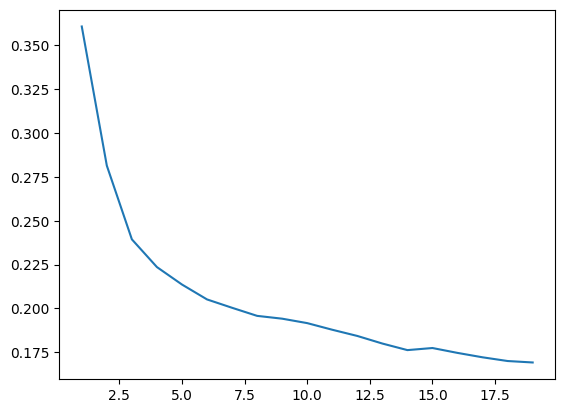

In [17]:
# We are going to study the problem of the number of images needed to calibrate the camera using a Pareto diagram
# We are going to use the same images as before

imgs_path = get_paths("left")
imgs = load_images(imgs_path)
corners = [cv2.findChessboardCorners(img, (8, 6)) for img in imgs]
imgs = [img for img, cor in zip(imgs, corners) if cor[0]]
corners = [cor for cor in corners if cor[0]]
corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01) # EPS + MAX_ITER, max 30 iterations, 0.01 accuracy(epsilon)
imgs_gray = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in imgs]
corners_refined = []
for i, cor in zip(imgs_gray, corners_copy):
    if cor[0]:
        corners_refined.append(cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria))
    else:
        print("No corners found in image")

imgs_with_corners = [cv2.drawChessboardCorners(imgs[i], (8, 6), corners_refined[i], corners[i][0]) for i in range(len(imgs)) if corners[i][0]]

results = {}

for n_imagenes in range(1, len(imgs)+1):
    chessboard_points = [get_chessboard_points((8,6), 30, 30) for i in range(n_imagenes)]
    valid_corners = [cor[1] for cor in corners[:n_imagenes] if cor[0]]
    valid_corners = np.asarray(valid_corners, dtype=np.float32)

    rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, valid_corners, imgs_gray[0].shape[::-1], None, None)

    # Obtain extrinsics
    extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

    # Print outputs
    results[n_imagenes] = rms

import matplotlib.pyplot as plt

plt.plot(list(results.keys()), list(results.values()))
    

The minimum number of images required to calibrate a camera is 10-15 images, less than this number may not provide accurate calibration results.

## **Apartado B: Corrección de distorsión** (ojo de pez)

En este apartado se trabajará en la corrección de la distorsión debido a lentes de ojo de pez. Primero se calibrará una cámara con este tipo de lente, utilizando las imágenes de la carpeta ``fisheye``. Posteriormente se utilizarán estos parámetros de calibración para corregir la distorsión de una de las imágenes de calibración.

Los pasos que deberá seguir para calibrar una cámara con distorsión de ojo de pez son:

1. Reutilice el método ``load_images()`` para cargar las imágenes de la carpeta ``fisheye``.
2. Detecte las equinas procesando las imágenes con los métodos ``cv2.findChessboardCorners()`` y ``cv2.cornerSubPix()``.
3. Reutilice la función ``get_chessboard_points()`` para obtener las coordenadas del tablero.
4. Defina los argumentos para la función de calibración.
5. Calibre con ``cv2.fisheye.calibrate()``

### **Tarea B.1:** Reutilice el método ``load_images()`` para cargar las imágenes de la carpeta ``fisheye``

In [38]:
# TODO Build a list containing the paths of all images from the fisheye camera and load images
fisheye_imgs_path = get_paths("fisheye", "VMRImage")
fisheye_imgs = load_images(fisheye_imgs_path)

C:\Users\javie\AppData\Local\Temp\ipykernel_4888\283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


### **Tarea B.2:** Detecte las equinas procesando las imágenes con los métodos ``cv2.findChessboardCorners()`` y ``cv2.cornerSubPix()``.

In [39]:
imgs_corners = []
# Parameters for cv2.cornerSubPix()
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
#TODO Complete the required parts of the loop
for img in fisheye_imgs:
    
    corners = cv2.findChessboardCorners(img, (7, 6))
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    refined_corners = cv2.cornerSubPix(gray_img, corners[1], (3,3), (-1,-1), subpix_criteria)

    # TODO append only those refined_corners with proper detections
    if corners[0]:
        imgs_corners.append(refined_corners)
        
print("Number of images with detected corners: ", len(imgs_corners))

Number of images with detected corners:  10


### **Tarea B.3:** Reutilice la función ``get_chessboard_points()`` para obtener las coordenadas del tablero

In [40]:
# TODO Define the chessboard dimensions and the lenght of the squares (in [mm])
chessboard_dims = (7, 6)
length = 30
fisheye_chessboard_points = get_chessboard_points(chessboard_dims, length, length)

### **Tarea B.4:** Defina los argumentos para la calibración

In [41]:
# Parameters for cv2.fisheye.calibrate()
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
intrinsics = np.zeros((3, 3))
distortion = np.zeros((4, 1))
rotations = [np.zeros((1, 1, 3), dtype=np.float64) for _ in imgs_corners]
traslations = [np.zeros((1, 1, 3), dtype=np.float64) for _ in imgs_corners]


### **Tarea B.5:** Calibración

In [42]:
imgs_corners = np.asarray(imgs_corners, dtype=np.float32)

rms, _, _, _, _ = \
cv2.fisheye.calibrate(fisheye_chessboard_points, imgs_corners, gray_img.shape[::-1], intrinsics, distortion, rotations, traslations, calibration_flags, subpix_criteria)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fisheye.cpp:752: error: (-215:Assertion failed) !objectPoints.empty() && !imagePoints.empty() && objectPoints.total() == imagePoints.total() in function 'cv::fisheye::calibrate'


In [ ]:
# Show intrinsic matrix and distortion coefficients values
print(intrinsics)
print(distortion)

### **Pregunta B.1:** Corrija la distorsión de las 2 primeras imágenes de la carpeta ``fisheye``

In [43]:
# TODO Search in the documentation to define 'dim'
dim = gray_img.shape[::-1]
map1, map2 = cv2.fisheye.initUndistortRectifyMap(intrinsics, distortion, np.eye(3), intrinsics, dim, cv2.CV_16SC2)

In [44]:
# correct distortion using cv2.remap()

for img in fisheye_imgs:
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    show_image(undistorted_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite("undistorted.jpg", undistorted_img)

    